# Problem Set 3 - Sergi Quintana Garcia

IMPORTANT!!! I have solved the PS following the instructions in the pdf. The day of handing the PS (Thursday 29th) I noticed Albert emailed us saying we  should also include policy functions plots. I did not include them following the PS instructions, I dnt have time to include them. I hope that value functions plots are enoguh. It is not very different to plot policy funcitons.
## Question 1. Value Function Iteration

Consider a Stationary economy populated by a large number of identical infinitely lived households that maximize: 
\begin{align*}
    E_0 \bigg\{ \sum_{t=0}^\infty \beta^t u(c_t,h_t)\bigg\}
\end{align*}
over consumption and leisure $u(c_t,1-h_t) = \ln c_t - \kappa\frac{h_t^{1+\frac{1}{\nu}}}{1+\frac{1}{\nu}}$ subject to:
\begin{align*}
    c_t + i_t =y_t
\end{align*}
\begin{align*}
    y_t= k_t^{1-\theta} (h_t)^{\theta}
\end{align*}
\begin{align*}
    i_t = k_{t+1} - (1-\delta) k_t
\end{align*}

Set $\theta=.679$,$\beta=.988$, $\delta=.013$. Also, to start with, set $h_t=1$, that is, labor is inelastically supplied. To compute the steady-state normalize output to one. 

### 1. Pose the recursive formulation of the sequential problem without productivity shocks, Discretize the state space and the value function and solve for it under the computational variants listed below. In all these variants use the same initial guess for your value function.

Before going into Python let me write the problem in recursive form.IMPORTANT:

1. Control Variable: $k$
2. Choice Variables: $k',c$

\begin{align*}
    V(k) = \max_{\{k',c\} \in A} \ln c_t -\kappa \frac{1}{1+\frac{1}{\nu}} + \beta V(k')
\end{align*}
where:
\begin{align*}
    A= \{(k',c) | c+i = y , y = k^{1-\theta}, i_t = k'-(1-\delta)k , c >0 \}
\end{align*}

So we can rewrite the problem as: 
\begin{align*}
    V(k) = \max_{\{k'\} \in [0,k^{1-\theta}+(1-\delta)k)} \ln (k^{1-\theta}-k'+(1-\delta)k) -\kappa \frac{1}{1+\frac{1}{\nu}} + \beta V(k')
\end{align*}

Notice that it is interesting to find the value of $k$ at the steady state to define our grid properly. To do so I will characterize the Euler equation in sequential form and then impose stationary.  The problem is: 

\begin{align*}
    \max_{k_{t+1}} \sum_{t=0}^\infty \beta^t \left(\ln (k_t^{1-\theta} + (1-\delta)k_t -k_{t+1}) -\frac{\kappa}{1+\frac{1}{\nu}}\right)
\end{align*}
the Foc gives: 
\begin{align*}
\frac{\partial}{\partial k_{t+1}} = 0 \Longleftrightarrow  \frac{\beta^{t+1}( (1-\theta) k_{t+1}^{-\theta}+1-\delta)}{(k_{t+1}^{1-\theta} + (1-\delta)k_{t+1} -k_{t+2})}
=\frac{\beta^t}{(k_t^{1-\theta} + (1-\delta)k_t -k_{t+1})}
\end{align*}

And now if we impose stationary we get:
\begin{align*}
    \beta ((1-\theta)k^{-\theta}+1-\delta)=1  \Longleftrightarrow k_{ss} =\left( \frac{1-\theta}{\frac{1}{\beta} - 1 + \delta}\right)^{\frac{1}{\theta}} 
\end{align*}

And now, following the recommendations of the lecture notes we can discretize $k$ in a grid with $k_{max}$ slightly above the steady state.

#### (a) Solve with brute force iterations of the value function. Plot your value function.

Number of iterations: 519
TOC: Elapsed: 0:00:18.16
Algoritham takes 18.164 seconds to run
42.552547163136246


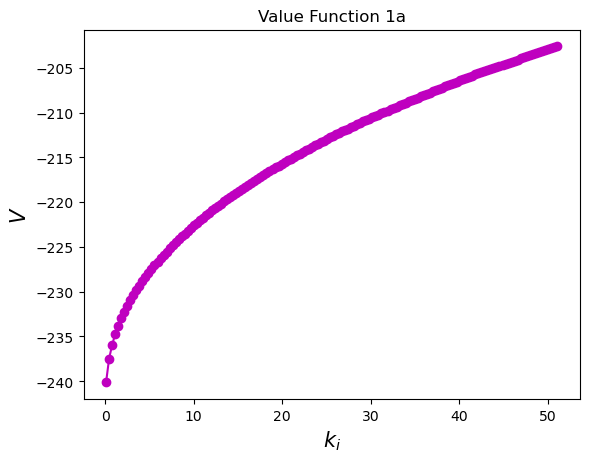

In [3]:
# Now we can solve the problem. I will follow the STEPS in the slides: QM-Value_Functions_Metods.pdf

# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

# Define the parameters: 

theta = 0.679
beta = 0.988
delta = 0.013
kappa = 5.24
nu = 2

# To start set h_t=1. Also define K at the Steady State. 

h = 1                                               # Inelastic labor supply

kss = ((1-theta)/((1/beta)-1+delta)) ** (1/theta)   # Steady State Capital

# STEP 1. Discretize the continous variable k: 

n = 150             # Number of discrete point to evaluate

kmin = 0.1          # Initial Grid value (slightly higher than 0 following the lecture notes)

kmax = 1.2*kss      # Maximal Grid Value (20% Above Steady State)

grid = np.linspace(kmin,kmax,n)   # Discrete grid of k

# STEP 2. I make the guess V^{s=0}(k_i)=0.

V = np.zeros(shape=(1,n))    # Initial Guess

# STEP 3 & 4. Generate the return matrix M. Not all values of c are feasible. 

# Generate a function that will evaluate the current utility, that is u(f(k_i)+(1-delta)k_i-k_j): 

def utility (k1,k2):
    "This function returs the utility given k_i and k_j with the form u() = ln(k1^{1-θ} + (1-δ)k1-k2)"
    # Inputs:
        #--> Capital today:    k1
        #--> Capital tomorrow: k2
        
    u = np.log(k1**(1-theta)+ (1-delta)*k1 - k2) - (kappa/(1+(1/nu)))
    return u

# As suggested by the slides I will change not feasible values by a very negative number omega:

omega = -1000 

# Define a function that gives the maximum k_j feasible given k_i
def feasible(k1):
    "Returns the maximum feasible k_j given k_i with the form : f(k_i)+(1-δ)k_i"
    # Inputs:
        #--> Capital today:    k1
    f = k1**(1-theta)+ (1-delta)*k1
    return f

# Generate the matrix M following the lecture notes : 

M = np.zeros(shape=(n,n))     # Empty matrix that later will become the utility evaluated at every possible combination of k_i and k_j

for i in range(n):
    for j in range(n):
        if feasible(grid[i]) >= grid[j]: 
            M[i][j] = utility(grid[i],grid[j])    # Gives the element ij of matrix M
        else: 
            M[i][j] = omega

# Important !! --> I have to do Step 3 and 4 at the same time since the log of a negative value is not well defined, so I have to prevent this. 


# STEP 5 & 6. Compute the matrix X. Solve for V^{s+1} and check for tolerance.

epsilon = 0.005    # Tolerance level.

def VFI(M,V,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations "
    # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
    
    qe.tic()                       # Starts to count the time this functions takes to run
    
    X  = np.zeros(shape=(n,n))     # Empty Array that will hold all possible Bellman equations
    
    Vnew = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    
    # Loop to generate X:
    for i in range(n):
        for j in range(n):
            X[i][j] = M[i][j] + beta*V[0][j]
    
    # Get the max of all the possible X[i] given j:

    for i in range(n):
        Vnew[0][i] = np.amax(X[i][:])     # New iteration for V
    
    # Generate the new value function and repeat the process until tolerance is satisfied:
    
    count=0                                 # Will count the number of iterations
    while np.any(abs(V-Vnew>= epsilon)):    # Generate a loop as long as tolerance is not satisfied
        V = Vnew.copy()
        for i in range(n):
            for j in range(n):         
                X[i][j] = M[i][j] + beta*Vnew[0][j]
    
        for i in range(n):    
            Vnew[0][i] = np.amax(X[i][:])
        count +=1
 
    print('Number of iterations: '+str(count)) 
    
    T = qe.toc()     # Stops counting time
    
    print('Algoritham takes '+ str(round(T,3)) + ' seconds to run')
    return V
    
ValueFunction1 = VFI(M,V,epsilon).T


# Plot Value Function:

fig, ax = plt.subplots()
ax.plot(grid,ValueFunction1,'m-o')
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 1a")

print(kss)

In [5]:
print(kss)

42.552547163136246


#### (b) Iterations of the value function taking into account monotonicity of the optimal decision rule. 

Now the intention is to reduce the number of points to be searched on the grid by the VFI algorithm. We know that the optimal decision rule increases in k. Therefore, if $k_j>k_i$, then $g(k_j) \geq g(k_i)$. For this reason we know that if we want to find $g(k_j)$ when $k_j>k_i$ we can rule out searching for all grid values of capital that are smaller than $g(k_i)$.

My strategy to solve this question is modify the VFI function created in the previous question, and include the optimal decision rule. The idea of this algorithm is that it only search in a grid where $k_j$ is higher than $g(k_i)$. So we need to construct the grid, called space, and then iterate on that grid. This will reduce the number of points to check and improves the speed of the algorithm. Notice that there will be points that are not computed. Those points might become a maximum if we not iterate on them. For this reason,I set the matrix X= omega, where omega is a very negative number. This ensure that those points that we are not iterating are very negative and are not taken as a maximum accidentally.Notice that since in this concrete exercice we are dealing with negative value function values, If we dont iterate some points, they will be less negative than those we iterate and can be accidentally chosen as maximums. This might not happen if the value funtion was taking positive values.

Number of iteraionts 519
TOC: Elapsed: 0:00:17.56
Algorithm takes 17.566 seconds to run


Text(0.5, 1.0, 'Value Function 1b')

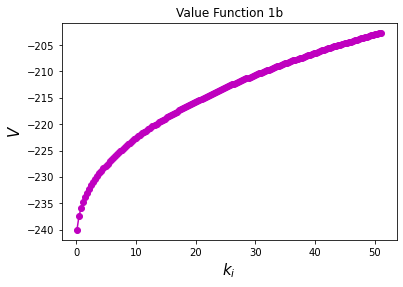

In [32]:
# STEP 5.1. Include the optimal decision rule. 

def VFI_2(M,V,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations "
    # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
    
    qe.tic()
    
    X  = np.zeros(shape=(n,n))     # Empty Array that will hold all possible Bellman equations
    
    Vnew = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    
    g = np.zeros(shape=(1,n))      # Array for optimal decision rule
    # Loop to generate X:
    for i in range(n):
        for j in range(n):
            X[i][j] = M[i][j] + beta*V[0][j]
    
    # Get the max of all the possible X[i] given j:

    for i in range(n):
        Vnew[0][i] = np.amax(X[i][:])       # New iteration for V
        g[0][i] = np.argmax(X[i][:])        # The optimal decision rule
    # Generate the new value function and repeat the process until tolerance is satisfied:
    count=0  
    while np.any(abs(V-Vnew>= epsilon)):    # Generate a loop as long as tolerance is not satisfied
        V = Vnew.copy()
        X=np.ones(shape=(n,n))*omega        # This speeds up the algorithm, now we just need to replace by those satifying monotonicity.
        for i in range(n):
            
            # Generate the space to search:
            
            space  = np.int_(np.linspace(np.int_(g[0][i]),n-1,n-np.int_(g[0][i])))
            
            for j in space:
                
                X[i][j] = M[i][j] + beta*Vnew[0][j]
                
                    
        for i in range(n):    
            Vnew[0][i] = np.amax(X[i][:])
            g[0][i] = np.argmax(X[i][:])
        count +=1
    print('Number of iteraionts '+str(count))
    
    T = qe.toc()
    
    print('Algorithm takes ' + str(round(T,3)) + ' seconds to run' )
    
    return V




ValueFunction2= VFI_2(M,V,epsilon).T

fig, ax = plt.subplots()
ax.plot(grid,ValueFunction2,'m-o')
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 1b")


The algorithm improves the speed and does the same number of iterations, so it seems to be performing good. 

#### (c) Iterations of the value function taking into account concavity of the value function. 

From our lecture notes we know that the maximand in the Bellman equation, $M_{i,j} + \beta V_j$, is strictly concave in $k'$. Therefore, if $M_{i,j} + \beta V_j>M_{i,j+1} + \beta V_{k+1}$, then $M_{i,j} + \beta V_j>M_{i,j+2} + \beta V_{k+2}$. Therefore, to make more efficient our algorithm we can include this condition. 

My strategy here is the following. I will iterate each row of $X$ until I reach a point where $X_{i,j-1}>X_{i,j}$. At this point I will stope iterating on that row and I will move to the next one. This is how I will speed up the algorithm. As before, since those values of $X_{i,j}$ that comes after the  $k_j$ that makes $X_{i,j-1}>X_{i,j}$ will not be computed I will set them to omega, where omega is a very negative number. This avoids choosing them accidentally as a maximum. Notice that since in this concrete exercice we are dealing with negative value function values, If we dont iterate some points, they will be less negative than those we iterate and can be accidentally chosen as maximums. This might not happen if the value funtion was taking positive values.

Number of iteraionts: 519
TOC: Elapsed: 0:00:17.02
Algorithm takes 17.025 seconds to run


Text(0.5, 1.0, 'Value Function 1c')

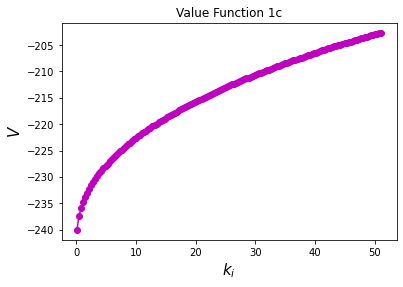

In [33]:
# The new algorithm is: 

def VFI_3(M,V,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations,considering concavity on k' "
     # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
    
    qe.tic()                       # Starts to count time
    
    X  = np.zeros(shape=(n,n))     # Empty Array that will hold all possible Bellman equations
    
    Vnew = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    
    # Loop to generate X:
    for i in range(n):
        for j in range(n):
            X[i][j] = M[i][j] + beta*V[0][j]
    
    # Get the max of all the possible X[i] given j:

    for i in range(n):
        Vnew[0][i] = np.amax(X[i][:])     # New iteration for V
        
    # Generate the new value function and repeat the process until tolerance is satisfied:
    count=0  
    while np.any(abs(V-Vnew>= epsilon)):    # Generate a loop as long as tolerance is not satisfied
        V = Vnew.copy()
        X=np.ones(shape=(n,n))*omega
        for i in range(n):
            for j in range(n): 
                if j>0:
                    
                    X[i][j] = M[i][j] + beta*Vnew[0][j]
                    
                    if X[i][j-1]<=X[i][j]:
                        continue
                    if X[i][j-1]>X[i][j]:
                        
                        break

                if j == 0:
                    
                    X[i][j] = M[i][j] + beta*Vnew[0][j]
   
           
        for i in range(n):    
            Vnew[0][i] = np.amax(X[i][:])
        count +=1
    print('Number of iteraionts: '+str(count))
    
    T = qe.toc()
    
    print('Algorithm takes ' + str(round(T,3)) + ' seconds to run' )
    
    return V

ValueFunction3 = VFI_3(M,V,epsilon).T

fig, ax = plt.subplots()
ax.plot(grid,ValueFunction3,'m-o')
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 1c")


In [1]:
print(grid)

NameError: name 'grid' is not defined

#### (d) Iterations of the value function taking into account local search on the decision rule. 

Following the lecture notes we know that if $k_j = g(k_i)$ then it is reasonable to think that $g(k_{i+1})$ is in a small neigborhood of $k_j$.

My strategy here is to compute the optimal decision rule and then generate a grid around that point. This grid is called neigh. The grid is composed by 7 points so we now just need to iterate on those points, instead of in all the 150 intial grid. This saves time. Notice that the points that we will not compute will remain unchanged (and hence become a maximum) unless specified. For this reason, as previously done, I set the matrix X = omega, being omega a very negative number. This ensures that the points not computed are very negative and not taken as a maximum wrongly. 

Number of iteraionts: 519
TOC: Elapsed: 0:00:7.64
Algorithm takes 7.642 seconds to run


Text(0.5, 1.0, 'Value Function 1d')

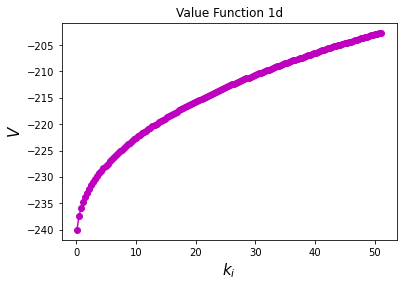

In [8]:
# The new algorithm is:

def VFI_4(M,V,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations, considering local search "
     # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)     
    # Output:
        # --> Returns fixed point value function.
    
    qe.tic()                       # Starts to count time
    
    X  = np.zeros(shape=(n,n))     # Empty Array that will hold all possible Bellman equations
    
    Vnew = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    
    g = np.zeros(shape=(1,n))      # Array for optimal decision rule ( to define the neighborhood around)
    
    k = 3                          # Will define the size of the set of neigborhoods. Size = 2k
    # Loop to generate X:
    for i in range(n):
        for j in range(n):
            X[i][j] = M[i][j] + beta*V[0][j]
    
    # Get the max of all the possible X[i] given j:

    for i in range(n):
        Vnew[0][i] = np.amax(X[i][:])     # New iteration for V
        g[0][i] = np.argmax(X[i][:])      # The optimal decision rule
    # Generate the new value function and repeat the process until tolerance is satisfied:
    
        count=0
    
    while np.any(abs(V-Vnew>= epsilon)):    # Generate a loop as long as tolerance is not satisfied
        V = Vnew.copy()
        X=np.ones(shape=(n,n))*omega        # This speeds up the algorithm, now we just need to replace by those satifying monotonicity. 
        for i in range(n):
            
            # Generate a grid for neighborhoods search: (more conditions need to be added if we change k)
            
            if g[0][i] == 0:
                neigh = np.int_(np.linspace(0,2*k,2*k+1))
            if g[0][i] == 1:
                 neigh = np.int_(np.linspace(0,2*k,2*k+1))
            if g[0][i] == 2:
                neigh = np.int_(np.linspace(0,2*k,2*k+1))
            if g[0][i]>2:
                neigh = np.int_(np.linspace(g[0][i]-k,g[0][i]+k,2*k+1))
            if g[0][i] == n-1:
                neigh = np.int_(np.linspace(n-1-2*k,n-1,2*k+1))
            if g[0][i] == n-2:
                neigh = np.int_(np.linspace(n-1-2*k,n-1,2*k+1))
            if g[0][i] == n-3:
                neigh = np.int_(np.linspace(n-1-2*k,n-1,2*k+1))
                
            for j in neigh:     # Just search on neighborhoods
                
                    X[i][j] = M[i][j] + beta*Vnew[0][j]
                                    
        for i in range(n):    
            Vnew[0][i] = np.amax(X[i][:])
            g[0][i] = np.argmax(X[i][:])
        count +=1
    print('Number of iteraionts: '+str(count))
    
    T = qe.toc()     # Stops counting time
    
    print('Algorithm takes ' + str(round(T,3)) + ' seconds to run' )
    
    return V

ValueFunction4 = VFI_4(M,V,epsilon).T

fig, ax = plt.subplots()
ax.plot(grid,ValueFunction4,'m-o')
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 1d")

The number of iterations is the same but the time to run has importantly been reduced. The algorithim seems to be performing good.

#### (e) Iterations on the value function taking into account both concavity of the value function and monotonicity of the decision rule. 


Basically we can combine (b) and (c) to reduce the grid to search and improve the speed. 


Number of iteraionts: 519
TOC: Elapsed: 0:00:8.11
Algorithm takes 8.115 seconds to run


Text(0.5, 1.0, 'Value Function 1e')

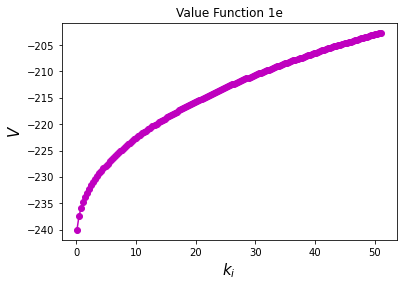

In [9]:
def VFI_5(M,V,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations,considering concavity on k' "
     # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
    
    qe.tic()
    
    X  = np.zeros(shape=(n,n))     # Empty Array that will hold all possible Bellman equations
    
    Vnew = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    
    g = np.zeros(shape=(1,n))      # Array for optimal decision rule
    
    # Loop to generate X:
    
    for i in range(n):
        for j in range(n):
            X[i][j] = M[i][j] + beta*V[0][j]
    
    # Get the max of all the possible X[i] given j:

    for i in range(n):
        Vnew[0][i] = np.amax(X[i][:])       # New iteration for V
        g[0][i] = np.argmax(X[i][:])        # The optimal decision rule
    # Generate the new value function and repeat the process until tolerance is satisfied:
    count=0  
    while np.any(abs(V-Vnew>= epsilon)):    # Generate a loop as long as tolerance is not satisfied
        V = Vnew.copy()
        X=np.ones(shape=(n,n))*omega
        for i in range(n):
            
            # Generate the space to search: (From Optimal Policy Rule)
            
            space  = np.int_(np.linspace(np.int_(g[0][i]),n-1,n-np.int_(g[0][i])))
            
            for j in space: 
                if j>0:
                    
                    X[i][j] = M[i][j] + beta*Vnew[0][j]
                    
                    if X[i][j-1]<=X[i][j]:    # From Concavity property
                        continue
                    if X[i][j-1]>X[i][j]:     # From Concavity property
                        
                        break

                if j == 0:
                    
                    X[i][j] = M[i][j] + beta*Vnew[0][j]
   
           
        for i in range(n):    
            Vnew[0][i] = np.amax(X[i][:])
            g[0][i] = np.argmax(X[i][:])
        count +=1
    print('Number of iteraionts: '+str(count))
    
    T = qe.toc()
    
    print('Algorithm takes ' + str(round(T,3)) + ' seconds to run' )
    
    return V

ValueFunction5 = VFI_5(M,V,epsilon).T

fig, ax = plt.subplots()
ax.plot(grid,ValueFunction5,'m-o')
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 1e")

#### (f) Use Howard's policy iterations waiting until converged to solve the problem. Start the policy iteration at three different iterations of the value function, and report the differences. 

Following our lecture notes we know that this method does not rely on the properties of the optimal value function or decision rule. The idea is to apply a guessed decision rule many times to update the value function, without solving for the decision rule at each iteration.  For this reason we will need to decide how many times we will update the value function without changing the decision rule.  In my algorithm funciton, this is chosen by the input "p". 

My strategy here is to allow the algorithm to depend on p, so that we can choose how much iterations on the value funciton are done without computing again the optimal decision rule. My first guess decision rule is the optimal decision rule obtained at the first iteration of the value function. the gains in speed here comes through two channels. The first is that we do not need to compute the optimal decision rule at each iteration, just after p iterations. The second gain of speed is that we do not need to find the maximum value for each row of the matrix X, we impose it to be the one following the optimal decision rule. 

Number of iteraionts 515
TOC: Elapsed: 0:00:21.02
Algorithm takes 21.029 seconds to run


Text(0.5, 1.0, 'Value Function 1f')

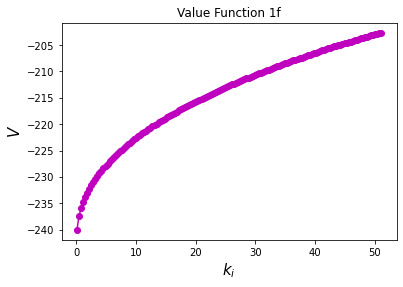

In [10]:
# The new algorithm is: 

def VFI_6(M,V,epsilon,p):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations, considering Howards policy "
    # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)
        # --> p (number of howard policy iterations)      
    # Output:
        # --> Returns fixed point value function.
    
    qe.tic()
    
    X  = np.zeros(shape=(n,n))     # Empty Array that will hold all possible Bellman equations
    
    Vnew = np.zeros(shape=(1,n))   # Array for new iteriation of V. 
    
    g = np.zeros(shape=(1,n))      # Array for optimal decision rule
    # Loop to generate X:
    for i in range(n):
        for j in range(n):
            X[i][j] = M[i][j] + beta*V[0][j]
    
    # Get the max of all the possible X[i] given j:

    for i in range(n):
        Vnew[0][i] = np.amax(X[i][:])       # New iteration for V
        g[0][i] = np.argmax(X[i][:])
    # Generate the new value function and repeat the process until tolerance is satisfied:
    count=0      
    policy=0  

    while np.any(abs(V-Vnew>= epsilon)):    # Generate a loop as long as tolerance is not satisfied
        V = Vnew.copy()
        X=np.ones(shape=(n,n))*omega        # This speeds up the algorithm, now we just need to replace by those satifying monotonicity.
        for i in range(n):
            for j in range(n):
                     X[i][j] = M[i][j] + beta*Vnew[0][j]   # Just compute those values that will be chosen following the optimal policy rule
                
        for i in range(n):    
            Vnew[0][i] = X[i][np.int_(g[0][i])]
        count +=1
        policy +=1
        
        if policy == p:
            for i in range(n):
                g[0][i]=np.argmax(X[i][:])
                policy = 0
        else:
            continue
            
    print('Number of iteraionts '+str(count))
    
    T = qe.toc()
    
    print('Algorithm takes ' + str(round(T,3)) + ' seconds to run' )
    
    return V


p=5

ValueFunction6= VFI_6(M,V,epsilon,p).T

fig, ax = plt.subplots()
ax.plot(grid,ValueFunction5,'m-o')
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 1f")

#### (g) Use policy iterations with 5,10,20 and 50 steps in between policy reassessments. 

Basically I need to evaluate the previous function for those different values of p. 

For 5 steps in between policy reassessments
Number of iteraionts 515
TOC: Elapsed: 0:00:19.95
Algorithm takes 19.955 seconds to run
For 10 steps in between policy reassessments
Number of iteraionts 508
TOC: Elapsed: 0:00:19.13
Algorithm takes 19.131 seconds to run
For 20 steps in between policy reassessments
Number of iteraionts 490
TOC: Elapsed: 0:00:19.15
Algorithm takes 19.156 seconds to run
For 50 steps in between policy reassessments
Number of iteraionts 278
TOC: Elapsed: 0:00:10.71
Algorithm takes 10.712 seconds to run


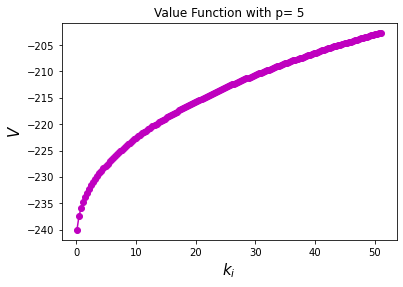

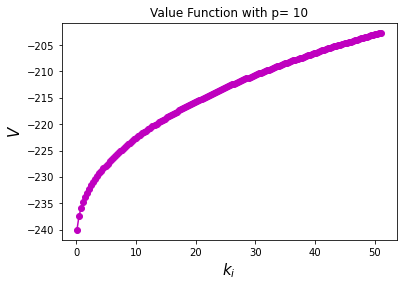

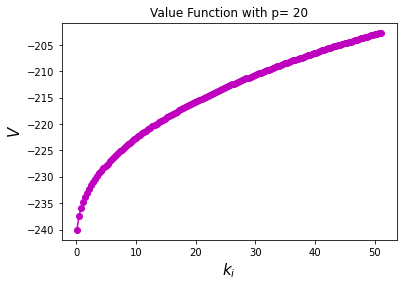

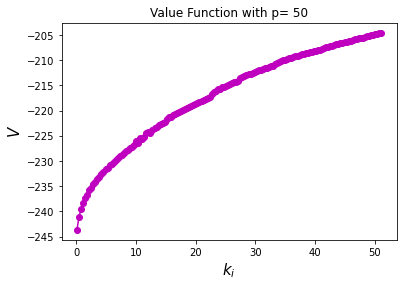

In [17]:
# The results are: 

for p in (5,10,20,50):
    print ("For "+ str(p) + " steps in between policy reassessments")
    
    ValueFunctionX= VFI_6(M,V,epsilon,p).T

    fig, ax = plt.subplots()
    ax.plot(grid,ValueFunctionX,'m-o')
    plt.ylabel("$V$",fontsize=15)
    plt.xlabel("$k_i$",fontsize=15)
    plt.title("Value Function with p= " + str(p))





The results obtained show three important things: 

1. The higher the amount of steps between iterations, the less iterations it takes to reach the fix point. 

2. The higher the amount of steps between iterations, the faster the algorithm works. 

3. The higher the amount of steps between iterations, the less precise it might become. This can be seen in the case of p = 50. The value function reported seems to differ from all the previous ones reported on all the sections. 

#### Overall conclusions from the exercice:

I will not writte the speed here since every time I run the code it slightly changes. The main conclusions are:

1. All the algirthims seems to be performing good since they all find the same fixed point (expect for Howard's with a very high p which is very similar but slightly different). 

2. Consistently with my intentions all the algorithms are faster compared to brute force iteration of part 1.a. 

3. Consistently with my intentions the algorithm of part 1.4 (mergering concavity and optimal policy rule properties) is faster than each of them separately. 

## Question 2. Redo item 1 adding a labor choice that is continuous. For this, set $\kappa=5.24$ and $\nu=2$

The main difference with the previous section is that now we will work with arrays of three dimensions to allow for labor decisions, and we also need to maximize the labor decision. 

#### (a) Solve by brute force iterations of the value function. Plot your value function.

Notice that since this algorithm needs to consider labor, the number of operations has been highly increased. For this reason, I have decided to reduce the size of the grid and to increase the tolerance so that the algorithm goes faster. After trying different specifications of the grid and the tolerance I found that results with a grid for k of 50 and a grid for h of 25 together with a tolerance of 0.05 do not have any significant difference with specificantions with a higher grid or with lower tolerance. For example, if we set gridk = 100 and tolerance 0.01 the code will take 5 minutes to run and the results do not have any significant change. For this reason I will use the parametrization mentinoed before, since the trade off between speed and results seems perfect. Notice that the grid for h can be smaller than the grid for k since this will give enough precision given that the interval of h is smaller than that for k.

My strategy here is the following. I am using the same function I created for part 1.a and I am increasing the dimensionality of the matrix X so that it can now store also labor choices. Then, for a given $k_i$ and $k_j$ I am choosing the optimal level of $h$. Once I have it I am choosing the optimal $k_j$ (or the maximum of the value function). I am repeating this process until tolerance is satisfied. I have noticed this strategy is not optimal since I can simultaneously choose labor and capital at the same time, for this reason I have two codes for 2.a. 

Number of iterations: 243
TOC: Elapsed: 0:00:39.24
Algoritham takes 39.249 seconds to run


Text(0.5, 1.0, 'Value Function 2a')

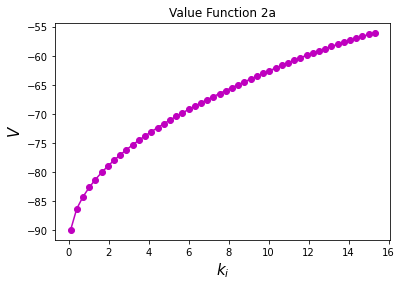

In [46]:
# Define the new capital in the steady state, also labor: 

kss  = (1-theta)/((1/beta)-1+delta)    # Capital in the steady state

hss = (1/kss**(1-theta))**(1/theta)    # Labor in the steady state (we dont need it)

# NOW REPEAT THE SAME STEPS AS IN PART 1.A.

# Discretize the domain of capital and labor: 

# STEP 1. Discretize the continous variable k: 

nk = 50             # Number of discrete point to evaluate in capital

nl = 25             # Number of discrete points to evaluate in labor

kmin = 0.1          # Initial Grid value (slightly higher than 0 following the lecture notes)

kmax = 1.2*kss      # Maximal Grid Value (20% Above Steady State)

gridk = np.linspace(kmin,kmax,nk)   # Discrete grid of k

hmin = 0            # Minimum value for labor

hmax = 1            # Maximum value for labor

gridl = np.linspace(hmin,hmax,nl)   # Discrete grid of h

# STEP 2. I make the guess V^{s=0}(k_i)=0.

V = np.zeros(shape=(1,nk))    # Initial Guess

# STEP 3 & 4. Generate the return matrix M. Not all values of c are feasible. 

# Generate a function that will evaluate the current utility, that is u(f(k_i)+(1-delta)k_i-k_j): 

def utility (k1,k2,h):
    "This function returs the utility given k_i, k_j and h with the form u() = ln(k1^{1-θ} h^{θ} + (1-δ)k1-k2)"
    # Inputs:
        #--> Capital today:    k1
        #--> Capital tomorrow: k2
        #--> Labor today:      h
        
    u = np.log(k1**(1-theta)*h**(theta)+ (1-delta)*k1 - k2) - (kappa*h**(1+(1/nu))/(1+(1/nu)))
    return u

# As suggested by the slides I will change not feasible values by a very negative number omega:

omega = -1000 

# Define a function that gives the maximum k_j feasible given k_i
def feasible(k1,h):
    "Returns the maximum feasible k_j given k_i and h with the form : f(k_i)+(1-δ)k_i"
    # Inputs:
        #--> Capital today:    k1
        #--> Labor today:      h
    f = k1**(1-theta)*h**(theta)+ (1-delta)*k1
    return f

# Generate the matrix M following the lecture notes : 

M = np.zeros(shape=(nk,nk,nl))     # Empty array that later will become the utility evaluated at every possible combination of k_i,k_j and h

for i in range(nk):
    for j in range(nk):
        for z in range(nl):        
            if feasible(gridk[i],gridl[z]) >= gridk[j]: 
                M[i][j][z] = utility(gridk[i],gridk[j],gridl[z])    # Gives the element ijz of matrix M
            else: 
                M[i][j][z] = omega

# STEP 5 & 6. Compute the matrix X. Solve for V^{s+1} and check for tolerance.

epsilon = 0.05    # Tolerance level.

def laborVFI(M,V,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations "
    # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
    
    qe.tic()                          # Starts to count the time this functions takes to run
    
    X  = np.zeros(shape=(nk,nk,nl))   # Empty Array that will hold all possible Bellman equations
    
    Vnew = np.zeros(shape=(1,nk))     # Array for new iteriation of V. 
    
    L = np.zeros(shape=(nk,nk))       # Array after choosing the optimal labor.
    
    # Loop to generate X:
    for i in range(nk):
        for j in range(nk):
            for z in range(nl):
                X[i][j][z] = M[i][j][z] + beta*V[0][j]
                
            L[i][j] =  np.amax(X[i][j][:])      # Chose the optimal labor decision (maximize labor given k today)
      
    # Get the max of all the possible X[i] given j:

    for i in range(nk):
        Vnew[0][i] = np.amax(L[i][:])     # New iteration for V
    
    # Generate the new value function and repeat the process until tolerance is satisfied:
    
    count=0                                 # Will count the number of iterations
    while np.any(abs(V-Vnew>= epsilon)):    # Generate a loop as long as tolerance is not satisfied
        V = Vnew.copy()
        for i in range(nk):
            for j in range(nk):
                for z in range(nl):
                    X[i][j][z] = M[i][j][z] + beta*V[0][j]
                
                L[i][j] =  np.amax(X[i][j][:])      # Chose the optimal labor decision (maximize labor given k today)
                
    
        for i in range(nk):    
            Vnew[0][i] = np.amax(L[i][:])
        count +=1
 
    print('Number of iterations: '+str(count)) 
    
    T = qe.toc()     # Stops counting time
    
    print('Algoritham takes '+ str(round(T,3)) + ' seconds to run')
    return V
    
LaborValueFunction1 = laborVFI(M,V,epsilon).T


# Plot Value Function:

fig, ax = plt.subplots()
ax.plot(gridk,LaborValueFunction1,'m-o')
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 2a")


Number of iterations: 243
TOC: Elapsed: 0:00:32.01
Algoritham takes 32.014 seconds to run


Text(0.5, 1.0, 'Value Function 2a')

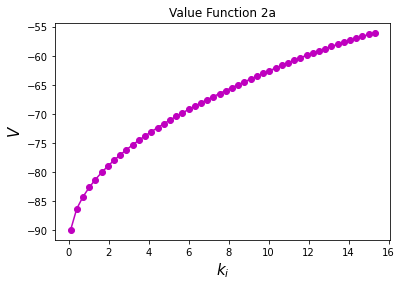

In [47]:
# FASTER (a): 

def laborVFIb(M,V,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations "
    # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
    
    qe.tic()                          # Starts to count the time this functions takes to run
    
    X  = np.zeros(shape=(nk,nk,nl))   # Empty Array that will hold all possible Bellman equations
    
    Vnew = np.zeros(shape=(1,nk))     # Array for new iteriation of V. 
    
    # Loop to generate X:
    for i in range(nk):
        for j in range(nk):
            for z in range(nl):
                X[i][j][z] = M[i][j][z] + beta*V[0][j]
                
      
    # Get the max of all the possible X[i] given j:

    for i in range(nk):
        Vnew[0][i] = np.amax(X[i][:][:])     # New iteration for V

    # Generate the new value function and repeat the process until tolerance is satisfied:
    
    count=0                                 # Will count the number of iterations
    while np.any(abs(V-Vnew>= epsilon)):    # Generate a loop as long as tolerance is not satisfied
        V = Vnew.copy()
        for i in range(nk):            
            for j in range(nk):
                for z in range(nl):
                    X[i][j][z] = M[i][j][z] + beta*V[0][j]
                
    
        for i in range(nk):    
            Vnew[0][i] = np.amax(X[i][:][:])      # Compute the new Value Function
        count +=1
 
    print('Number of iterations: '+str(count)) 
    
    T = qe.toc()     # Stops counting time
    
    print('Algoritham takes '+ str(round(T,3)) + ' seconds to run')
    return V
    
LaborValueFunction1b = laborVFIb(M,V,epsilon).T


# Plot Value Function:

fig, ax = plt.subplots()
ax.plot(gridk,LaborValueFunction1b,'m-o')
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 2a")

As we can see, the second function gives a faster performance to get the same result in the same number of iterations. 

#### (b) Iterations of the value function taking into account monotonicity of the optimal decision rule.



Number of iterations: 573
TOC: Elapsed: 0:01:9.42
Algoritham takes 69.421 seconds to run


Text(0.5, 1.0, 'Value Function 2b')

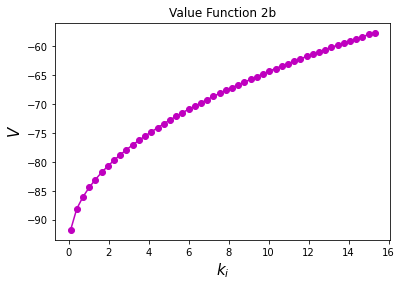

In [51]:
# The new algorithm is: 

def laborVFI_2(M,V,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations "
    # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
    
    qe.tic()                          # Starts to count the time this functions takes to run
    
    X  = np.zeros(shape=(nk,nk,nl))   # Empty Array that will hold all possible Bellman equations
    
    Vnew = np.zeros(shape=(1,nk))     # Array for new iteriation of V. 
    
    L = np.zeros(shape=(nk,nk))       # Array after choosing the optimal labor.
    
    g = np.zeros(shape=(1,nk))        # Array for optimal decision rule
    
    # Loop to generate X:
    for i in range(nk):
        for j in range(nk):
            for z in range(nl):
                X[i][j][z] = M[i][j][z] + beta*V[0][j]
                
            L[i][j] =  np.amax(X[i][j][:])      # Chose the optimal labor decision (maximize labor given k today)
      
    # Get the max of all the possible X[i] given j:

    for i in range(nk):
        Vnew[0][i] = np.amax(L[i][:])     # New iteration for V
        g[0][i] = np.argmax(L[i][:])      # Optimal Policy Rule
    
    # Generate the new value function and repeat the process until tolerance is satisfied:
    
    count=0                                 # Will count the number of iterations
    while np.any(abs(V-Vnew>= epsilon)):    # Generate a loop as long as tolerance is not satisfied
        V = Vnew.copy()
        X = np.ones(shape=(nk,nk,nl))*omega
        for i in range(nk):
            # Generate the space to search:
            
            space  = np.int_(np.linspace(np.int_(g[0][i]),nk-1,nk-np.int_(g[0][i])))
            
            for j in space:
                for z in range(nl):
                    X[i][j][z] = M[i][j][z] + beta*V[0][j]
                
                L[i][j] =  np.amax(X[i][j][:])      # Chose the optimal labor decision (maximize labor given k today)
                
    
        for i in range(nk):    
            Vnew[0][i] = np.amax(L[i][:])      # Compute the new Value Function
            g[0][i] = np.argmax(L[i][:])         # Compute the new policy rule 
        count +=1
 
    print('Number of iterations: '+str(count)) 
    
    T = qe.toc()     # Stops counting time
    
    print('Algoritham takes '+ str(round(T,3)) + ' seconds to run')
    return V
    
LaborValueFunction2 = laborVFI_2(M,V,epsilon).T


# Plot Value Function:

fig, ax = plt.subplots()
ax.plot(gridk,LaborValueFunction2,'m-o')
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 2b")

Even if the code gives the same resutlts, the performance is very poor and the time is increased. 

#### (c) Use concavity of the Value Function

My strategy here is to adapt the code developed in 1.c to a 3dimensional array. 

Number of iterations: 19
TOC: Elapsed: 0:00:1.97
Algoritham takes 1.977 seconds to run


Text(0.5, 1.0, 'Value Function 2c')

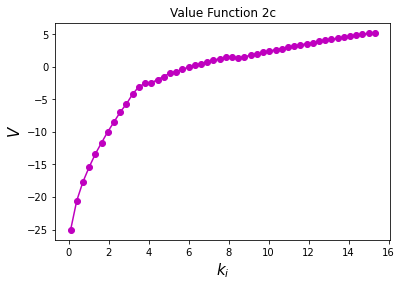

In [63]:

def laborVFI_3(M,V,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations "
    # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
    
    qe.tic()                          # Starts to count the time this functions takes to run
    
    X  = np.zeros(shape=(nk,nk,nl))   # Empty Array that will hold all possible Bellman equations
    
    Vnew = np.zeros(shape=(1,nk))     # Array for new iteriation of V. 
    
    # Loop to generate X:
    for i in range(nk):
        for j in range(nk):
            for z in range(nl):
                X[i][j][z] = M[i][j][z] + beta*V[0][j]
                
      
    # Get the max of all the possible X[i] given j:

    for i in range(nk):
        Vnew[0][i] = np.amax(X[i][:][:])     # New iteration for V

    # Generate the new value function and repeat the process until tolerance is satisfied:
    
    count=0                                 # Will count the number of iterations
    while np.any(abs(V-Vnew>= epsilon)):    # Generate a loop as long as tolerance is not satisfied
        V = Vnew.copy()
        for i in range(nk):
            for z in range(nl):
                for j in range(nk): 
                    if j>0:
                    
                        X[i][j][z] = M[i][j][z] + beta*V[0][j]
                    
                        if X[i][j-1][z]<=X[i][j][z]:
                            continue
                        if X[i][j-1][z]>X[i][j][z]:
                        
                            break

                    if j == 0:
                    
                        X[i][j][z] = M[i][j][z] + beta*V[0][j]
                
    
        for i in range(nk):    
            Vnew[0][i] = np.amax(X[i][:][:])      # Compute the new Value Function
        count +=1
 
    print('Number of iterations: '+str(count)) 
    
    T = qe.toc()     # Stops counting time
    
    print('Algoritham takes '+ str(round(T,3)) + ' seconds to run')
    return V
    
LaborValueFunction3 = laborVFI_3(M,V,epsilon).T


# Plot Value Function:

fig, ax = plt.subplots()
ax.plot(gridk,LaborValueFunction3,'m-o')
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 2c")



The code seems to be performing very poor, with non acceptable results. This might be because concavity of the value function might be affetec by the choice of labor. In the previous code I was not explicitly maximizing for labor. In the next code I try to add labor choice but it is not working properly. 

Number of iterations: 1
TOC: Elapsed: 0:00:0.41
Algoritham takes 0.42 seconds to run


Text(0.5, 1.0, 'Value Function 2cb')

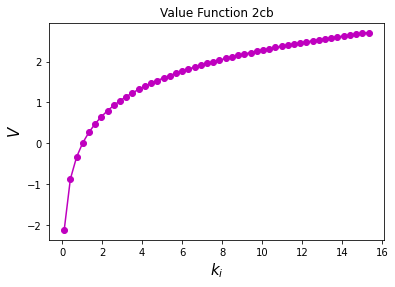

In [64]:
def laborVFI_3b(M,V,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations "
    # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
    
    qe.tic()                          # Starts to count the time this functions takes to run
    
    X  = np.zeros(shape=(nk,nk,nl))   # Empty Array that will hold all possible Bellman equations
    
    Vnew = np.zeros(shape=(1,nk))     # Array for new iteriation of V. 
    
    L = np.zeros(shape=(nk,nk))       # Array after choosing the optimal labor.
    
    # Loop to generate X:
    for i in range(nk):
        for j in range(nk):
            for z in range(nl):
                X[i][j][z] = M[i][j][z] + beta*V[0][j]
                
            L[i][j] =  np.amax(X[i][j][:])      # Chose the optimal labor decision (maximize labor given k today)
      
    # Get the max of all the possible X[i] given j:

    for i in range(nk):
        Vnew[0][i] = np.amax(L[i][:])     # New iteration for V
    
    # Generate the new value function and repeat the process until tolerance is satisfied:
    
    count=0                                 # Will count the number of iterations
    while np.any(abs(V-Vnew>= epsilon)):    # Generate a loop as long as tolerance is not satisfied
        V = Vnew.copy()
        for i in range(nk):
            for z in range(nl):
                for j in range(nk): 
                    if j>0:
                    
                        X[i][j][z] = M[i][j][z] + beta*V[0][j]
                    
                        if X[i][j-1][z]<=X[i][j][z]:
                            continue
                        if X[i][j-1][z]>X[i][j][z]:
                        
                            break

                    if j == 0:
                    
                        X[i][j][z] = M[i][j][z] + beta*V[0][j]
                
                
                L[i][j] =  np.amax(X[i][j][:])      # Chose the optimal labor decision (maximize labor given k today)
                
    
        for i in range(nk):    
            Vnew[0][i] = np.amax(L[i][:])
        count +=1
 
    print('Number of iterations: '+str(count)) 
    
    T = qe.toc()     # Stops counting time
    
    print('Algoritham takes '+ str(round(T,3)) + ' seconds to run')
    return V
    
LaborValueFunction3b = laborVFI_3b(M,V,epsilon).T


# Plot Value Function:

fig, ax = plt.subplots()
ax.plot(gridk,LaborValueFunction3b,'m-o')
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 2cb")

#### (d) Use local search

The code does not work since np.argmax(X[i][:][:])  retunrs indices higher than the range(nk). I don't know how to interpret those indices, once I find out, it can be easily changed. 


In [69]:
def laborVFIb(M,V,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations "
    # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
    
    qe.tic()                          # Starts to count the time this functions takes to run
    
    X  = np.zeros(shape=(nk,nk,nl))   # Empty Array that will hold all possible Bellman equations
    
    Vnew = np.zeros(shape=(1,nk))     # Array for new iteriation of V.
    
    g = np.zeros(shape=(1,nk))        # Array for optimal policy rule
    
    k=3 
    
    # Loop to generate X:
    for i in range(nk):
        for j in range(nk):
            for z in range(nl):
                X[i][j][z] = M[i][j][z] + beta*V[0][j]
                
      
    # Get the max of all the possible X[i] given j:

    for i in range(nk):
        Vnew[0][i] = np.amax(X[i][:][:])     # New iteration for V
        g[0][i] = np.argmax(X[i][:][:])

    # Generate the new value function and repeat the process until tolerance is satisfied:
    
    count=0                                 # Will count the number of iterations
    while np.any(abs(V-Vnew>= epsilon)):    # Generate a loop as long as tolerance is not satisfied
        V = Vnew.copy()
        X=np.ones(shape=(nk,nk,nl))*omega        # This speeds up the algorithm, now we just need to replace by those satifying monotonicity. 
        for i in range(nk):
             # Generate a grid for neighborhoods search: (more conditions need to be added if we change k)
            
            if g[0][i] == 0:
                neigh = np.int_(np.linspace(0,2*k,2*k+1))
            if g[0][i] == 1:
                 neigh = np.int_(np.linspace(0,2*k,2*k+1))
            if g[0][i] == 2:
                neigh = np.int_(np.linspace(0,2*k,2*k+1))
            if g[0][i]>2:
                neigh = np.int_(np.linspace(g[0][i]-k,g[0][i]+k,2*k+1))
            if g[0][i] == nk-1:
                neigh = np.int_(np.linspace(nk-1-2*k,nk-1,2*k+1))
            if g[0][i] == nk-2:
                neigh = np.int_(np.linspace(nk-1-2*k,nk-1,2*k+1))
            if g[0][i] == nk-3:
                neigh = np.int_(np.linspace(nk-1-2*k,nk-1,2*k+1))
            for j in neigh:
                for z in range(nl):
                    X[i][j][z] = M[i][j][z] + beta*V[0][j]
                
    
        for i in range(nk):    
            Vnew[0][i] = np.amax(X[i][:][:])      # Compute the new Value Function
            g[0][i] = np.argmax(X[i][:][:])
        count +=1
 
    print('Number of iterations: '+str(count)) 
    
    T = qe.toc()     # Stops counting time
    
    print('Algoritham takes '+ str(round(T,3)) + ' seconds to run')
    return V
    
LaborValueFunction1b = laborVFIb(M,V,epsilon).T


# Plot Value Function:

fig, ax = plt.subplots()
ax.plot(gridk,LaborValueFunction1b,'m-o')
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 2a")

TypeError: 'numpy.float64' object does not support item assignment

## Quesiton 3

#### Repeat using continous interpolation methods.

Following the recomendation of Albert, I used a interpolation method different than Chebyshev since we have a predetermined funtion for it.

My strategy for the first code is basically interpolate the value function on the grid using the intial guess 0. Then I will iterate until tolerance is satisfied. The way to iterate is using a minimization algorithm since now we have a funciton and not a discretized space. The results seems to be satisfing. I did some speed up of the code but I did not have time to go over all the algorithms.

Number of iteraionts 364
TOC: Elapsed: 0:00:20.47
Algorithm takes 20.478 seconds to run


Text(0.5, 1.0, 'Value Function 3a')

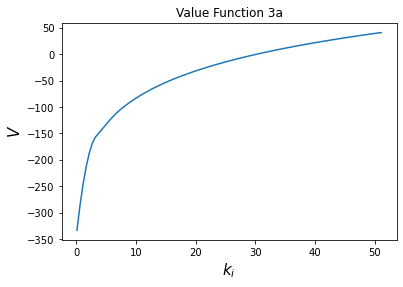

In [72]:
##############################################################################
### QUESTION 3 --> LINEAR INTERPOLATION



import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

# Define the parameters: 

theta = 0.679
beta = 0.988
delta = 0.013
kappa = 5.24
nu = 2

# To start set h_t=1. Also define K at the Steady State. 

h = 1                                               # Inelastic labor supply

kss = ((1-theta)/((1/beta)-1+delta)) ** (1/theta)   # Steady State Capital

# STEP 1. Discretize the continous variable k: 
    
# Notice the grid size is smaller than before since it is not needed now. 

n = 25              # Number of discrete point to evaluate ()

kmin = 0.1          # Initial Grid value (slightly higher than 0 following the lecture notes)

kmax = 1.2*kss      # Maximal Grid Value (20% Above Steady State)

grid = np.linspace(kmin,kmax,n)   # Discrete grid of k

def utility (k1,k2):
    "This function returs the utility given k_i and k_j with the form u() = ln(k1^{1-θ} + (1-δ)k1-k2)"
    # Inputs:
        #--> Capital today:    k1
        #--> Capital tomorrow: k2
        
    u = np.log(k1**(1-theta)+ (1-delta)*k1 - k2) - (kappa/(1+(1/nu)))
    return u

# As suggested by the slides I will change not feasible values by a very negative number omega:

omega = -1000 

# Define a function that gives the maximum k_j feasible given k_i
def feasible(k1):
    "Returns the maximum feasible k_j given k_i with the form : f(k_i)+(1-δ)k_i"
    # Inputs:
        #--> Capital today:    k1
    f = k1**(1-theta)+ (1-delta)*k1
    return f

# Make initial guess for value funciton: 
    
V1 = np.zeros(n)


# Define the interpolation of the value function: 
    
from scipy.optimize import minimize_scalar, minimize 
from scipy.interpolate import interp1d

epsilon= 0.05

def continuousVFI(V1,epsilon):
    
    qe.tic()
    
    V = lambda x: np.interp(x,grid,V1)        # Interpolate of the value functio
    
    Vnew = np.zeros(n)
    
    g = np.zeros(n)                           # Array for optimal policy rule
    
    for i in range(n): 
        
        bns = (0,feasible(grid[i]))                             # Ensures feasibility of the value function.
    
        Bellman= lambda x: -1*(utility(grid[i],x) + beta*V1[i])    # Bellman equation at the first initial guess.
        
        optimal = minimize_scalar(Bellman,bounds=bns,method='bounded')               # Maximize Bellman equaiton given k today. (Find k')
        
        g[i] = optimal.x
        
        Vnew[i] = -optimal.fun
        
    
    count=0             # Will count the number of iterations
    
    while np.any(abs(V1-Vnew>epsilon)):
        
        V1 = Vnew.copy() 
        
        V = lambda x: np.interp(x,grid,Vnew)        # Interpolate of the value functio
        
        for i in range(n): 
    
            bns = (0,feasible(grid[i]))                             # Ensures feasibility of the value function.
    
            Bellman= lambda x: -1*(utility(grid[i],x) + beta*V(grid[i]))    # Bellman equation at the first initial guess.
        
            optimal = minimize_scalar(Bellman,bounds=bns,method='bounded')           # Maximize Bellman equaiton given k today. (Find k')
        
            g[i] = optimal.x
            
            Vnew[i] = -optimal.fun
        
        count +=1
        
   
    print('Number of iteraionts '+str(count))
    
    T = qe.toc()
    
    print('Algorithm takes ' + str(round(T,3)) + ' seconds to run' )
        
    return Vnew


Value = continuousVFI(V1,epsilon)


r = 100     # New grid size

# Interpolate using the fixed point, and evaluate at a bigger grid: 

vfinal  = interp1d(grid,Value,kind='quadratic') # Interpolate using the fixed point

grid2 = np.linspace(kmin,kmax,r)   # Discrete grid of k

VFinal = vfinal(grid2)             # Evaluate the interpolated function at the fixed point

# Plot Value Function:

fig, ax = plt.subplots()
ax.plot(grid2,VFinal)
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 3a")


#### (b) Use monotonicity of the optimal policy to speed up the algorithm 

My strategy here is the following. Since we know that new optimum will be higher or equal than the last optimum, I will include the optimum policy rule as a lower bound in the bounds constraint. The results shows that the algorithm is faster but the difference is very small.

Number of iteraionts 366
TOC: Elapsed: 0:00:19.04
Algorithm takes 19.043 seconds to run


Text(0.5, 1.0, 'Value Function 3b')

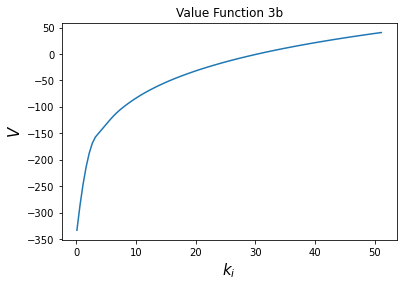

In [39]:
def continuousVFI_2(V1,epsilon):
    
    qe.tic()
    
    V = lambda x: np.interp(x,grid,V1)        # Interpolate of the value functio
    
    Vnew = np.zeros(n)
    
    g = np.zeros(n)                           # Array for optimal policy rule
    
    for i in range(n): 
        
        bns = (0,feasible(grid[i]))                             # Ensures feasibility of the value function.
    
        Bellman= lambda x: -1*(utility(grid[i],x) + beta*V1[i])    # Bellman equation at the first initial guess.
        
        optimal = minimize_scalar(Bellman,bounds=bns,method='bounded')               # Maximize Bellman equaiton given k today. (Find k')
        
        g[i] = optimal.x
        
        Vnew[i] = -optimal.fun
        
    
    count=0             # Will count the number of iterations
    
    while np.any(abs(V1-Vnew>epsilon)):
        
        V1 = Vnew.copy() 
        
        V = lambda x: np.interp(x,grid,Vnew)        # Interpolate of the value functio
        
        for i in range(n): 
    
            bns = (g[i],feasible(grid[i]))                             # Ensures feasibility of the value function.
    
            Bellman= lambda x: -1*(utility(grid[i],x) + beta*V(grid[i]))    # Bellman equation at the first initial guess.
        
            optimal = minimize_scalar(Bellman,bounds=bns,method='bounded')           # Maximize Bellman equaiton given k today. (Find k')
        
            g[i] = optimal.x
            
            Vnew[i] = -optimal.fun
        
        count +=1
        
   
    print('Number of iteraionts '+str(count))
    
    T = qe.toc()
    
    print('Algorithm takes ' + str(round(T,3)) + ' seconds to run' )
        
    return Vnew


Value2 = continuousVFI_2(V1,epsilon)



r = 100


vfinal  = interp1d(grid,Value2,kind='quadratic')

grid2 = np.linspace(kmin,kmax,r)   # Discrete grid of k

VFinal = vfinal(grid2)

fig, ax = plt.subplots()
ax.plot(grid2,VFinal)
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 3b")

#### (d) Use local search of the decision rule: 

My strategy here is the following. I will define a value kbond (not confund with capital) which will generate the rage to look at. Since the optimization problem allows for bounds I will put a very restricitve bound around the optimal point. The bound is $bound= (g[i]-k,g[i]+k)$. Some conditons ensure that this bound will be inside the feasible interval values of k. 

Number of iteraionts 366
TOC: Elapsed: 0:00:19.11
Algorithm takes 19.118 seconds to run


Text(0.5, 1.0, 'Value Function 3b')

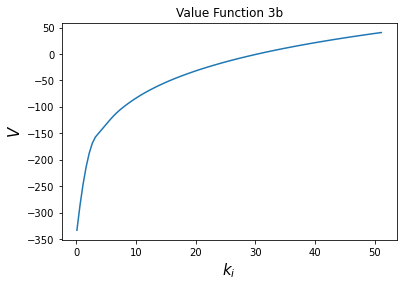

In [41]:
# Using local search:

def continuousVFI_3(V1,epsilon):
    
    qe.tic()
    
    V = lambda x: np.interp(x,grid,V1)        # Interpolate of the value functio
    
    Vnew = np.zeros(n)
    
    g = np.zeros(n)                           # Array for optimal policy rule
    
    kbond = 1           # Neighborhoods to look at
    
    for i in range(n): 
        
        bns = (0,feasible(grid[i]))                             # Ensures feasibility of the value function.
    
        Bellman= lambda x: -1*(utility(grid[i],x) + beta*V1[i])    # Bellman equation at the first initial guess.
        
        optimal = minimize_scalar(Bellman,bounds=bns,method='bounded')               # Maximize Bellman equaiton given k today. (Find k')
        
        g[i] = optimal.x
        
        Vnew[i] = -optimal.fun
        
    
    count=0             # Will count the number of iterations
    
    while np.any(abs(V1-Vnew>epsilon)):
        
        V1 = Vnew.copy() 
        
        V = lambda x: np.interp(x,grid,Vnew)        # Interpolate of the value functio
        
        for i in range(n): 
            if g[i]>kbond:
                bns = (g[i]-kbond,g[i]+kbond)                             # Local Search
            if g[i] == kbond:
                bns = (g[i]-kbond,g[i]+kbond) 
    
            bns = (g[i],feasible(grid[i]))                             # Ensures feasibility of the value function.
    
            Bellman= lambda x: -1*(utility(grid[i],x) + beta*V(grid[i]))    # Bellman equation at the first initial guess.
        
            optimal = minimize_scalar(Bellman,bounds=bns,method='bounded')           # Maximize Bellman equaiton given k today. (Find k')
        
            g[i] = optimal.x
            
            Vnew[i] = -optimal.fun
        
        count +=1
        
   
    print('Number of iteraionts '+str(count))
    
    T = qe.toc()
    
    print('Algorithm takes ' + str(round(T,3)) + ' seconds to run' )
        
    return Vnew


Value3 = continuousVFI_3(V1,epsilon)



r = 100


vfinal  = interp1d(grid,Value3,kind='quadratic')

grid2 = np.linspace(kmin,kmax,r)   # Discrete grid of k

VFinal = vfinal(grid2)

fig, ax = plt.subplots()
ax.plot(grid2,VFinal)
plt.ylabel("$V$",fontsize=15)
plt.xlabel("$k_i$",fontsize=15)
plt.title("Value Function 3b")    
    

Notice that the algorithm gives the same fixed point value function as the other methods and the time is slightly reduced but not significant. (less than a second). 

## Comparison

The results obtained with continous interpolation differs from those in discrite methods, this suggest that I might be doing a mistake in one of the methods. However, the overall functioning of the algorithm seems consistent in each method, which means that even if discrete or continout methos might be wrong, the speed up algorithms improves the speed in both and the results obtained are the same. 